Python中,并发并不是指同一时刻有多个操作(thread,task)同时进行.相反,某个特定时刻,它只允许有一个操作发生,只不过线程/任务之间会相互切换,直到完成

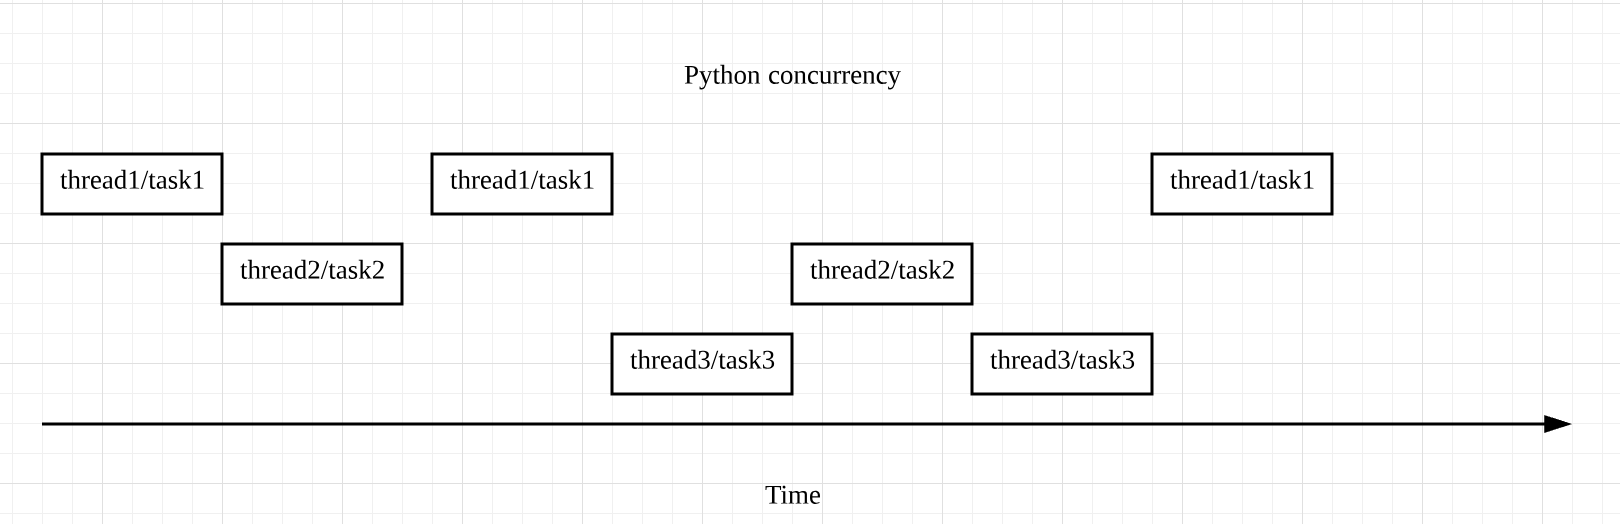

图中出现了thread和task两种切换顺序地不同方式,分别对应python中并发地两种形式->threading和asyncio

* 并发通常用于I/O操作频繁地场景,比如你要从网站上下载多个文件,I/O操作地时间可能会比CPU运行处理地时间长得多
* 而并行则更多应用于CPU heavy的场景,比如MapReduce中的并行计算,为了加快运行速度,一般会用多台机器,多个处理器来完成

### 并发编程之Futures

#### 单线程和多线程性能比较

假设有个任务是下载一些网站的内容并打印,如果单线程处理,代码实现如下:

In [2]:
import requests
import time

headers={
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.129 Safari/537.36"
}

def download_one(url):
    resp = requests.get(url,headers=headers)
    print("Read {} from {}".format(len(resp.content),url))

    
def download_all(sites):
    for site in sites:
        download_one(site)
 
    
def main():
    sites=[
        "https://baike.baidu.com/item/%E5%8E%86%E5%8F%B2/360?fr=aladdin",
        "https://baike.baidu.com/item/%E8%89%BA%E6%9C%AF/12004323?fr=aladdin",
        "https://baike.baidu.com/item/%E6%95%B0%E5%AD%A6/107037?fr=aladdin",
        "https://baike.baidu.com/item/%E7%94%9F%E7%89%A9/161443?fr=aladdin",
        "https://baike.baidu.com/item/java/85979",
        "https://baike.baidu.com/item/Python/407313"
    ]
    start_time = time.perf_counter()
    download_all(sites)
    end_time = time.perf_counter()
    print('Download {} sites in {} seconds'.format(len(sites), end_time - start_time))
    
if __name__ == '__main__':
    main()

Read 172314 from https://baike.baidu.com/item/%E5%8E%86%E5%8F%B2/360?fr=aladdin
Read 221257 from https://baike.baidu.com/item/%E8%89%BA%E6%9C%AF/12004323?fr=aladdin
Read 262924 from https://baike.baidu.com/item/%E6%95%B0%E5%AD%A6/107037?fr=aladdin
Read 246529 from https://baike.baidu.com/item/%E7%94%9F%E7%89%A9/161443?fr=aladdin
Read 210044 from https://baike.baidu.com/item/java/85979
Read 210268 from https://baike.baidu.com/item/Python/407313
Download 6 sites in 1.7111022999999932 seconds


#### 多线程版本

In [4]:
import concurrent.futures
import requests
import threading
import time


headers={
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.129 Safari/537.36"
}

def download_one(url):
    resp = requests.get(url,headers=headers)
    print('Read {} from {}'.format(len(resp.content), url))
 
 
def download_all(sites):
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        executor.map(download_one, sites)
        
        
def main():
    sites=[
        "https://baike.baidu.com/item/%E5%8E%86%E5%8F%B2/360?fr=aladdin",
        "https://baike.baidu.com/item/%E8%89%BA%E6%9C%AF/12004323?fr=aladdin",
        "https://baike.baidu.com/item/%E6%95%B0%E5%AD%A6/107037?fr=aladdin",
        "https://baike.baidu.com/item/%E7%94%9F%E7%89%A9/161443?fr=aladdin",
        "https://baike.baidu.com/item/java/85979",
        "https://baike.baidu.com/item/Python/407313"
    ]
    start_time = time.perf_counter()
    download_all(sites)
    end_time = time.perf_counter()
    print('Download {} sites in {} seconds'.format(len(sites), end_time - start_time))
    
if __name__ == '__main__':
    main()

Read 172314 from https://baike.baidu.com/item/%E5%8E%86%E5%8F%B2/360?fr=aladdin
Read 262924 from https://baike.baidu.com/item/%E6%95%B0%E5%AD%A6/107037?fr=aladdin
Read 210044 from https://baike.baidu.com/item/java/85979
Read 221257 from https://baike.baidu.com/item/%E8%89%BA%E6%9C%AF/12004323?fr=aladdin
Read 246529 from https://baike.baidu.com/item/%E7%94%9F%E7%89%A9/161443?fr=aladdin
Read 210268 from https://baike.baidu.com/item/Python/407313
Download 6 sites in 0.43872379999993427 seconds


主要区别在于我们创建了一个线程池,总共有5个线程可以分配使用.**executer.map()** 与前面所讲的Python内置的map()函数类似,表示对sites中的每个元素,并发的调用download_one() 

download_one()函数中,requests.get()方法是线程安全的
并行的方式去提高程序运行效率,需要在download_all()函数中,做出下面的变化:<br/>
with futures.ThreadPoolExecutor(workers) as executor<br/>
=><br/>
with futures.ProcessPoolExecutor() as executor

### 什么是Futures

Python中的Futrues模块,位于concurrent.futures和asyncio中,他们都表示带有延迟的操作.Futures会将处于等待状态的操作包裹起来放到队列中,这些操作的状态随时可以查询,当然,他们的结果或是异常,亦能够在操作完成后被获取

Futures中的方法done(),表示相对应的操作是否完成-True表示完成,False表示没有完成.不过,需要注意,done()是non-blocking的,会立即返回结果.相对应的add_done_callback(fn),则表示Futures完成后, 相对应的参数函数fn,会被通知并执行调用

Futures中还有一个重要的函数result(),它表示当future完成后,返回其对应的结果或者异常.而as_completed(fn),则是针对给定的future迭代器fs,在其完成后,返回完成后的迭代器

In [5]:
import concurrent.futures
import requests
import time

headers={
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.129 Safari/537.36"
}
 
def download_one(url):
    resp = requests.get(url,headers=headers)
    print('Read {} from {}'.format(len(resp.content), url))
 
def download_all(sites):
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        to_do = []
        for site in sites:
            #提交任务,返回future
            future = executor.submit(download_one, site)
            to_do.append(future)
            
        for future in concurrent.futures.as_completed(to_do):
            #获取future结果
            future.result()
def main():
    sites=[
        "https://baike.baidu.com/item/%E5%8E%86%E5%8F%B2/360?fr=aladdin",
        "https://baike.baidu.com/item/%E8%89%BA%E6%9C%AF/12004323?fr=aladdin",
        "https://baike.baidu.com/item/%E6%95%B0%E5%AD%A6/107037?fr=aladdin",
        "https://baike.baidu.com/item/%E7%94%9F%E7%89%A9/161443?fr=aladdin",
        "https://baike.baidu.com/item/java/85979",
        "https://baike.baidu.com/item/Python/407313"
    ]
    start_time = time.perf_counter()
    download_all(sites)
    end_time = time.perf_counter()
    print('Download {} sites in {} seconds'.format(len(sites), end_time - start_time))
 
if __name__ == '__main__':
    main()

Read 172314 from https://baike.baidu.com/item/%E5%8E%86%E5%8F%B2/360?fr=aladdin
Read 246529 from https://baike.baidu.com/item/%E7%94%9F%E7%89%A9/161443?fr=aladdin
Read 221257 from https://baike.baidu.com/item/%E8%89%BA%E6%9C%AF/12004323?fr=aladdin
Read 210044 from https://baike.baidu.com/item/java/85979
Read 262924 from https://baike.baidu.com/item/%E6%95%B0%E5%AD%A6/107037?fr=aladdin
Read 210268 from https://baike.baidu.com/item/Python/407313
Download 6 sites in 0.4626204000001053 seconds


python主程序之允许有一个线程执行,所以python的并发,是通过多线程的切换完成的
Python的解释器并不是线程安全的,为了解决由此带来的条件竞争,python引入了全局解释器锁,也就是同一时刻,只允许一个线程执行,当然,在执行I/O操作时,如果一个线程被block了,全局解释器锁便会被释放,从而让另一个线程能够继续执行